In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatboostIpythonWidget

## Examine data

In [2]:
%%capture
df = pd.read_csv('clinvar_20180225.ann.tsv.gz', compression='gzip', sep='\t', error_bad_lines=False, header=0)

In [3]:
len(df)

372159

In [4]:
df.head()

,#id,chrom,inputPos,inputRef,inputAlt,unannotatedReason,gene,geneId,geneDesc,transcript,...,granthamDist,AGVGDclass,AGVGDgv,AGVGDgd,SIFTprediction,SIFTweight,SIFTmedian,MAPPprediction,MAPPpValue,MAPPpValueMedian
0,475283,1,949422,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,178.468,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,183381,1,949523,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,475278,1,949597,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,402986,1,949608,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,130.977,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,161455,1,949696,C,CG,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

#id                       int64
chrom                    object
inputPos                  int64
inputRef                 object
inputAlt                 object
unannotatedReason        object
gene                     object
geneId                    int64
geneDesc                 object
transcript               object
strand                    int64
transLen                  int64
cdsLen                    int64
protein                  object
Uniprot                  object
varType                  object
codingEffect             object
varLocation              object
assembly                 object
gDNAstart                 int64
gDNAend                   int64
gNomen                   object
cDNAstart                object
cDNAend                  object
cNomen                   object
pNomen                   object
alt_pNomen               object
exon                      int64
intron                  float64
omimId                  float64
                         ...   
wtAA_3  

In [6]:
df.isnull().sum()

#id                          0
chrom                        0
inputPos                     0
inputRef                     0
inputAlt                     0
unannotatedReason            0
gene                         0
geneId                       0
geneDesc                     0
transcript                   0
strand                       0
transLen                     0
cdsLen                       0
protein                  16608
Uniprot                  88433
varType                      0
codingEffect            131716
varLocation                  0
assembly                     0
gDNAstart                    0
gDNAend                      0
gNomen                       0
cDNAstart                    0
cDNAend                      0
cNomen                       0
pNomen                    2380
alt_pNomen                2380
exon                         0
intron                  318115
omimId                   21182
                         ...  
wtAA_3                  158696
wtCodon 

## Preprocessing

### Filters

In [7]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
]


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df


df = df[RELEVANT_FEATURES]  # Filtering relevant features
df = rules_filter(df)  # Rules filtering
df.reset_index(drop=True, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,varMaxEntScore,rsMAF,1000g_AF,gnomadAltFreq_all,espAllMAF,espAllAAF,clinVarMethods,clinVarClinSignifs,nOrthos,conservedOrthos
0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,7.04863,0.006190,0.006190,0.001599,0.005459,0.005459,NaN,NaN,10.0,2.0
1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
2,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
3,1,949739,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,7.04863,0.000000,NaN,0.000008,NaN,NaN,literature only,Pathogenic,NaN,NaN
4,1,949851,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,7.04863,0.000799,0.000799,0.000265,0.000698,0.000698,NaN,NaN,10.0,2.0


### `inputPos` as regression parametr

In [8]:
df.inputPos = df.inputPos.astype(float)

### `clinVarMethods` split

In [9]:
def fetch_names(row, delimeters='|,'):
    def unify(name):
        return '_'.join(name.strip().lower().split())
    
    names = [row]
    for delimeter in delimeters:
        new_names = []
        for name in names:
            new_names.extend(name.split(delimeter))
        names = new_names
    return [unify(name) for name in names]


def collect_names(column, delimeters='|,'): 
    all_names = set()
    for row in column:
        all_names.update(set(fetch_names(row)))
    return all_names

In [10]:
df.clinVarMethods = df.clinVarMethods.fillna('NaN')
cvm_methods = {m: i for i, m in enumerate(list(collect_names(df.clinVarMethods)))}
cvm_features = []
for row in df.clinVarMethods:
    row_features = np.zeros(len(cvm_methods))
    for name in fetch_names(row):
        row_features[cvm_methods[name]] += 1
    cvm_features.append(row_features)
cvm_features = np.vstack(cvm_features)

cvm_columns = ['cvm_' + m for _, m in sorted([(i, m) for m, i in cvm_methods.items()])]
cvm_features = pd.DataFrame(cvm_features, columns=cvm_columns)
df = pd.concat([df, cvm_features], axis=1)
del df['clinVarMethods']
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_nan,cvm_in_vivo,cvm_curation,cvm_case-control,cvm_in_vitro,cvm_research,cvm_literature_only,cvm_reference_population,cvm_clinical_testing,cvm_phenotyping_only
0,1,949422.0,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,949851.0,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Making target

In [11]:
RELEVANCES = {'benign': 0, 'likely_benign': 1, 'not_provided': 2, 'vus': 2, 'likely_pathogenic': 3, 'pathogenic': 4}


def labelize_row(row):
    return max((RELEVANCES[name] for name in fetch_names(row) if name in RELEVANCES), default=2)


def labelize_target(y, bad_word='pathogenic'):
    return y.apply(labelize_row)
#     return y.apply(lambda x: int(bad_word in x.lower()))

In [12]:
df = df.loc[df.clinVarClinSignifs.notna()]
df.reset_index(drop=True, inplace=True)
df.rename({'clinVarClinSignifs': 'y'}, axis=1, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_nan,cvm_in_vivo,cvm_curation,cvm_case-control,cvm_in_vitro,cvm_research,cvm_literature_only,cvm_reference_population,cvm_clinical_testing,cvm_phenotyping_only
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## TT split

In [13]:
def tt_split(df):
    np.random.seed(42)
    df = df.copy()
    
    y = labelize_target(df.y)
    del df['y']
    X = df
    
    X = X.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
    
    cat_features = np.where(X.dtypes != np.float)[0]

    return (X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features

## NDCG

In [14]:
def split_relevance(relevance):
    return [r.lower() for it in relevance.split('|') for r in it.split(', ') if r.lower() in RELEVANCES]


def get_relevances(significances):
    return [split_relevance(significance) for significance in significances.values]


def dcg(relevances):
    return np.sum(2 ** relevances / np.log2(np.arange(2, relevances.size + 2)))


def evaluate_serp(df, sign, score, n=30):
    serp = df.sample(n=n, replace=False)
    rel_true = np.array([RELEVANCES[np.random.choice(sign[index], size=1)[0]] for index, row in serp.iterrows()])

    order_true = np.argsort(rel_true)[::-1]
    serp = serp.iloc[order_true]
    rel_true = rel_true[order_true]

    order_pred = np.argsort(score[serp.index])[::-1]
    rel_pred = rel_true[order_pred]
    
    return dcg(rel_pred) / dcg(rel_true)


def evaluate(df, sign, score, k=1000, n=30):
    np.random.seed(42)
    return np.mean([evaluate_serp(df, sign, score, n) for _ in range(k)])

In [15]:
sign = pd.Series(data=get_relevances(df.y), index=df.index)
not_empty = [it != [] for it in sign]
df = df[not_empty]
sign = sign[not_empty]
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_nan,cvm_in_vivo,cvm_curation,cvm_case-control,cvm_in_vitro,cvm_research,cvm_literature_only,cvm_reference_population,cvm_clinical_testing,cvm_phenotyping_only
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1,955601.0,C,T,NM_001305275.1,missense,exon,p.Leu17Phe,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Run

In [16]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features = tt_split(df)
len(X_train), len(X_validate), len(X_test)

(101593, 25399, 31749)

In [17]:
model = CatBoostClassifier(iterations=300, loss_function='MultiClass')

In [18]:
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_validate, y_validate),
          plot=False);

0:	learn: -1.5134615	test: -1.5135573	best: -1.5135573 (0)	total: 1.17s	remaining: 5m 48s
1:	learn: -1.4300324	test: -1.4302791	best: -1.4302791 (1)	total: 2.08s	remaining: 5m 10s
2:	learn: -1.3565076	test: -1.3568414	best: -1.3568414 (2)	total: 3.11s	remaining: 5m 7s
3:	learn: -1.2908917	test: -1.2912682	best: -1.2912682 (3)	total: 3.98s	remaining: 4m 54s
4:	learn: -1.2319076	test: -1.2324172	best: -1.2324172 (4)	total: 4.93s	remaining: 4m 51s
5:	learn: -1.1784973	test: -1.1790495	best: -1.1790495 (5)	total: 6.05s	remaining: 4m 56s
6:	learn: -1.1297742	test: -1.1303703	best: -1.1303703 (6)	total: 7.06s	remaining: 4m 55s
7:	learn: -1.0851862	test: -1.0858360	best: -1.0858360 (7)	total: 8.17s	remaining: 4m 58s
8:	learn: -1.0441212	test: -1.0448000	best: -1.0448000 (8)	total: 9.17s	remaining: 4m 56s
9:	learn: -1.0061098	test: -1.0068505	best: -1.0068505 (9)	total: 10.2s	remaining: 4m 56s
10:	learn: -0.9708342	test: -0.9716803	best: -0.9716803 (10)	total: 11.4s	remaining: 4m 59s
11:	learn

90:	learn: -0.2806216	test: -0.2798738	best: -0.2798738 (90)	total: 2m 7s	remaining: 4m 52s
91:	learn: -0.2787943	test: -0.2781587	best: -0.2781587 (91)	total: 2m 8s	remaining: 4m 51s
92:	learn: -0.2772036	test: -0.2765246	best: -0.2765246 (92)	total: 2m 10s	remaining: 4m 50s
93:	learn: -0.2756033	test: -0.2748787	best: -0.2748787 (93)	total: 2m 12s	remaining: 4m 50s
94:	learn: -0.2740047	test: -0.2732416	best: -0.2732416 (94)	total: 2m 14s	remaining: 4m 49s
95:	learn: -0.2724303	test: -0.2716821	best: -0.2716821 (95)	total: 2m 16s	remaining: 4m 49s
96:	learn: -0.2711081	test: -0.2702864	best: -0.2702864 (96)	total: 2m 17s	remaining: 4m 47s
97:	learn: -0.2699464	test: -0.2691166	best: -0.2691166 (97)	total: 2m 18s	remaining: 4m 45s
98:	learn: -0.2686963	test: -0.2678548	best: -0.2678548 (98)	total: 2m 19s	remaining: 4m 43s
99:	learn: -0.2674414	test: -0.2665874	best: -0.2665874 (99)	total: 2m 21s	remaining: 4m 42s
100:	learn: -0.2662356	test: -0.2653825	best: -0.2653825 (100)	total: 2m

177:	learn: -0.2197452	test: -0.2208855	best: -0.2208855 (177)	total: 4m 5s	remaining: 2m 48s
178:	learn: -0.2194721	test: -0.2206690	best: -0.2206690 (178)	total: 4m 6s	remaining: 2m 46s
179:	learn: -0.2191652	test: -0.2203641	best: -0.2203641 (179)	total: 4m 7s	remaining: 2m 45s
180:	learn: -0.2188012	test: -0.2199946	best: -0.2199946 (180)	total: 4m 9s	remaining: 2m 43s
181:	learn: -0.2185074	test: -0.2197117	best: -0.2197117 (181)	total: 4m 10s	remaining: 2m 42s
182:	learn: -0.2182205	test: -0.2194234	best: -0.2194234 (182)	total: 4m 11s	remaining: 2m 40s
183:	learn: -0.2178493	test: -0.2190640	best: -0.2190640 (183)	total: 4m 12s	remaining: 2m 39s
184:	learn: -0.2177083	test: -0.2189771	best: -0.2189771 (184)	total: 4m 13s	remaining: 2m 37s
185:	learn: -0.2173220	test: -0.2186186	best: -0.2186186 (185)	total: 4m 14s	remaining: 2m 36s
186:	learn: -0.2171088	test: -0.2184265	best: -0.2184265 (186)	total: 4m 16s	remaining: 2m 34s
187:	learn: -0.2168728	test: -0.2182191	best: -0.21821

264:	learn: -0.2061671	test: -0.2085602	best: -0.2085602 (264)	total: 5m 54s	remaining: 46.9s
265:	learn: -0.2060969	test: -0.2085069	best: -0.2085069 (265)	total: 5m 56s	remaining: 45.5s
266:	learn: -0.2059759	test: -0.2084043	best: -0.2084043 (266)	total: 5m 57s	remaining: 44.2s
267:	learn: -0.2058749	test: -0.2083280	best: -0.2083280 (267)	total: 5m 58s	remaining: 42.9s
268:	learn: -0.2057791	test: -0.2082411	best: -0.2082411 (268)	total: 6m	remaining: 41.5s
269:	learn: -0.2057042	test: -0.2081793	best: -0.2081793 (269)	total: 6m 1s	remaining: 40.2s
270:	learn: -0.2056483	test: -0.2081111	best: -0.2081111 (270)	total: 6m 2s	remaining: 38.8s
271:	learn: -0.2055560	test: -0.2080461	best: -0.2080461 (271)	total: 6m 4s	remaining: 37.5s
272:	learn: -0.2053859	test: -0.2078703	best: -0.2078703 (272)	total: 6m 5s	remaining: 36.1s
273:	learn: -0.2052691	test: -0.2077445	best: -0.2077445 (273)	total: 6m 6s	remaining: 34.8s
274:	learn: -0.2051631	test: -0.2076859	best: -0.2076859 (274)	total:

In [19]:
y_pred = model.predict(X_test)[:, 0]
(y_pred == y_test).sum() / len(y_test)

0.9346751078774135

In [20]:
score = pd.Series(data=y_pred, index=X_test.index)
evaluate(X_test, sign, score)

0.9835874283811308

## Analysis

In [21]:
model.get_params()

{'iterations': 300, 'loss_function': 'MultiClass'}

In [22]:
def draw_importance(columns, importances):
    order = np.argsort(importances)
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    plt.show()

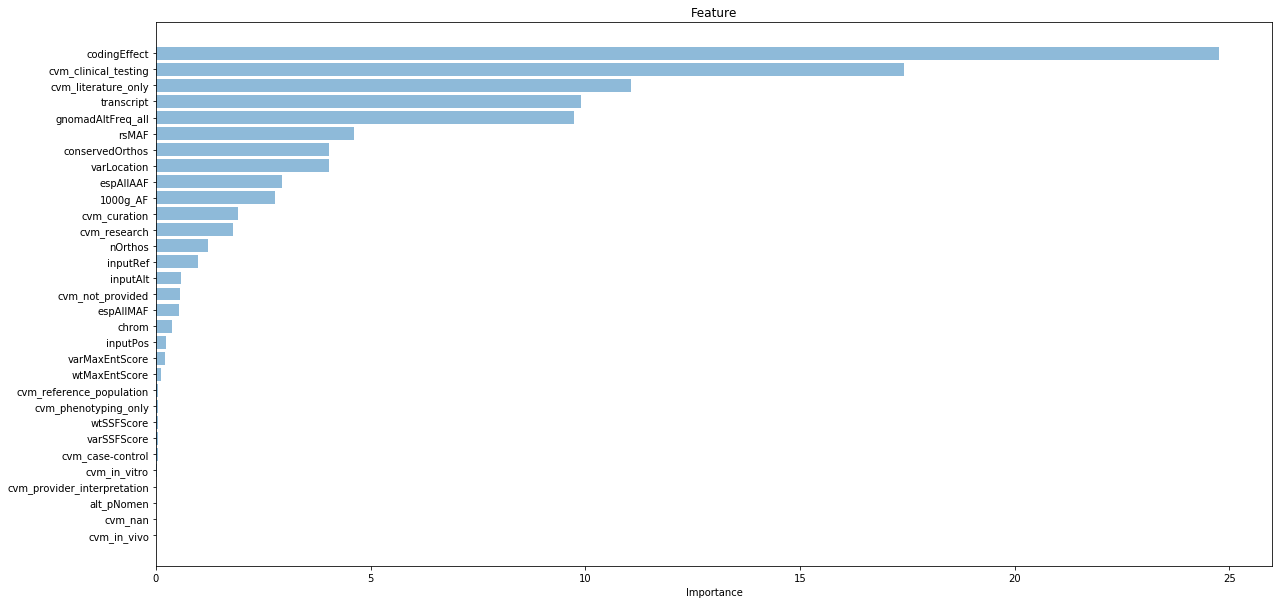

In [23]:
draw_importance(X_train.columns, model.feature_importances_)